# CIFAR-10 classification
## 1. Baseline
### 1.1.  import libraries and define hyperparameters

In [1]:
!pip -q install cleverhans
!pip -q install einops
!pip -q install ptflops

     |████████████████████████████████| 327kB 14.4MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 163kB 21.2MB/s 


In [2]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt 
import numpy as np
import os 
from ptflops import get_model_complexity_info
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision.models import resnet34, resnet101, mobilenet_v2
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [4]:
device = 'cuda'

### 1.2. load and normalize CIFAR-10

In [5]:
batch_size = 256

In [6]:
mean = [0.5, 0.5, 0.5]
std =  [0.5, 0.5, 0.5]
transform_train = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [7]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1.3. define a transformer

In [8]:
class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 32, 32)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 8, 8)
        return out

In [9]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [10]:
class HybridViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super(HybridViT,self).__init__()
        self.ResNetFeatures = ResNetFeatures()
        self.image_size = image_size // 4
        self.patch_size = self.image_size // (image_size//patch_size)
        self.channels = 64
        self.ViT = ViT(image_size=self.image_size,
            patch_size=self.patch_size, 
            num_classes=num_classes, 
            dim=dim, 
            depth=depth, 
            heads=heads, 
            mlp_dim=mlp_dim,
            pool='cls',
            channels=self.channels, 
            dim_head=64,
            dropout=0.,
            emb_dropout = 0.)
        
    def forward(self, img):
        x = self.ResNetFeatures(img)
        x = self.ViT(x)
        return x

In [11]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

class FeedForward_v2(nn.Module):
    def __init__(self):
        super().__init__()
        inplanes=planes=1
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)

    def forward(self, x):
        x = torch.unsqueeze(x,1)
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = torch.squeeze(x,1)
        return out

class Transformer_v2(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward_v2())
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT_v2(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer_v2(dim, depth, heads, dim_head, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

class HybridViT_v2(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        self.ResNetFeatures = ResNetFeatures()
        self.image_size = image_size // 4
        self.patch_size = self.image_size // (image_size//patch_size)
        self.channels = 64
        self.ViT = ViT_v2(image_size=self.image_size,
            patch_size=self.patch_size, 
            num_classes=num_classes, 
            dim=dim, 
            depth=depth, 
            heads=heads, 
            mlp_dim=mlp_dim,
            pool='cls',
            channels=64, 
            dim_head=64,
            dropout=0.,
            emb_dropout = 0.)
        
    def forward(self, img):
        x = self.ResNetFeatures(img)
        x = self.ViT(x)
        return x

In [ ]:
resnet_feature = ResNetFeatures().to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


model 1: Pure ViT, add resnet_feature head.


In [ ]:
model = ViT(
    image_size=8,
    patch_size=4,
    num_classes=10,
    dim = 512,
    depth = 12,
    heads = 16,
    channels=64,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

model2: Hybrid ViT, with a trainable resnet head

In [ ]:
model = HybridViT(
    image_size=32,
    patch_size=16,
    num_classes=10,
    dim = 512,
    depth = 10,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

model 3: ViT version 2, add resnet_feature head

In [ ]:
model = ViT_v2(
    image_size=8,
    patch_size=4,
    num_classes=10,
    dim = 512,
    depth = 12,
    heads = 16,
    channels=64,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

简直逆天 还有这么拉的玩意儿

model 4: Hybrid ViT version 2, change the feedforward to be convolution 

In [12]:
model = HybridViT_v2(
    image_size=32,
    patch_size=16,
    num_classes=10,
    dim = 512,
    depth = 10,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Let's see the parameter numbers and FLOPs of Hybrid ViT

In [13]:
macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.12 GMac
Number of parameters:           21.76 M 


### 1.4. Let's start our training!

In [ ]:
lr = 3e-5

In [14]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

NameError: ignored

In [ ]:
loss_record = {'train': [], 'validation': []} 
acc_record = {'train': [], 'validation': []} 

In [44]:
def train(epochs, model, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer, scheduler=None, resnet_feature=None, adv_train=False):
    #optimizer.zero_grad()
    #optimizer.step()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        print("current lr = %lf"%optimizer.param_groups[0]['lr'])

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            # with torch.no_grad():
            #     data = resnet_feature(data)
            if adv_train:
                # Replace clean example with adversarial example for adversarial training
                data = projected_gradient_descent(model, data, 0.3, 0.01, 40, np.inf)
            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
        
        # scheduler.step()

        loss_record['train'].append(epoch_loss.detach().cpu().item())
        acc_record['train'].append(epoch_accuracy.detach().cpu().item())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)
                # data = resnet_feature(data)
                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
            loss_record['validation'].append(epoch_val_loss.detach().cpu().item())
            acc_record['validation'].append(epoch_val_accuracy.detach().cpu().item())

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

In [ ]:
epochs = 20

In [ ]:
train(epochs, model, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer)

current lr = 0.000003



Epoch : 1 - loss : 0.5920 - acc: 0.7931 - val_loss : 0.6987 - val_acc: 0.7576

current lr = 0.000003



Epoch : 2 - loss : 0.5787 - acc: 0.7979 - val_loss : 0.7010 - val_acc: 0.7586

current lr = 0.000003



Epoch : 3 - loss : 0.5752 - acc: 0.7970 - val_loss : 0.7076 - val_acc: 0.7499

current lr = 0.000003



Epoch : 4 - loss : 0.5701 - acc: 0.8014 - val_loss : 0.6993 - val_acc: 0.7606

current lr = 0.000003



Epoch : 5 - loss : 0.5720 - acc: 0.7991 - val_loss : 0.6897 - val_acc: 0.7571

current lr = 0.000003



Epoch : 6 - loss : 0.5625 - acc: 0.8034 - val_loss : 0.6913 - val_acc: 0.7628

current lr = 0.000003



Epoch : 7 - loss : 0.5633 - acc: 0.8032 - val_loss : 0.7080 - val_acc: 0.7573

current lr = 0.000003



Epoch : 8 - loss : 0.5673 - acc: 0.8024 - val_loss : 0.6787 - val_acc: 0.7673

current lr = 0.000003



Epoch : 9 - loss : 0.5681 - acc: 0.8011 - val_loss : 0.7078 - val_acc: 0.7489

current lr = 0.000003



Epoch : 10 - loss : 0.5598 - acc: 0.8032 - val_loss : 0.7032 - val_acc: 0.7533

current lr = 0.000003



Epoch : 11 - loss : 0.5639 - acc: 0.8020 - val_loss : 0.6915 - val_acc: 0.7565

current lr = 0.000003



Epoch : 12 - loss : 0.5558 - acc: 0.8038 - val_loss : 0.6952 - val_acc: 0.7605

current lr = 0.000003



Epoch : 13 - loss : 0.5567 - acc: 0.8051 - val_loss : 0.6885 - val_acc: 0.7626

current lr = 0.000003



Epoch : 14 - loss : 0.5553 - acc: 0.8050 - val_loss : 0.7042 - val_acc: 0.7594

current lr = 0.000003



Epoch : 15 - loss : 0.5560 - acc: 0.8056 - val_loss : 0.7001 - val_acc: 0.7525

current lr = 0.000003



Epoch : 16 - loss : 0.5581 - acc: 0.8064 - val_loss : 0.7036 - val_acc: 0.7584

current lr = 0.000003



Epoch : 17 - loss : 0.5543 - acc: 0.8059 - val_loss : 0.7031 - val_acc: 0.7579

current lr = 0.000003



Epoch : 18 - loss : 0.5539 - acc: 0.8045 - val_loss : 0.7130 - val_acc: 0.7510

current lr = 0.000003



Epoch : 19 - loss : 0.5497 - acc: 0.8073 - val_loss : 0.6955 - val_acc: 0.7526

current lr = 0.000003



Epoch : 20 - loss : 0.5581 - acc: 0.8055 - val_loss : 0.7112 - val_acc: 0.7579



In [58]:
def plot_loss_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(min(record['train'])-0.05,max(record['train'])+0.05)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_acc_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(min(record['train'])-0.05,max(record['train'])+0.05)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Accurary curve of {}'.format(title))
    plt.legend()
    plt.show()


In [ ]:
%matplotlib inline

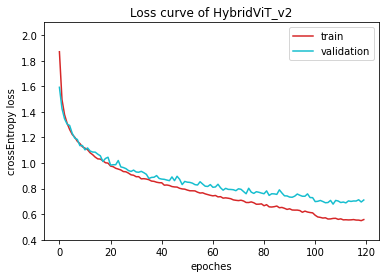

In [ ]:
plot_loss_curve(loss_record, title='HybridViT_v2')

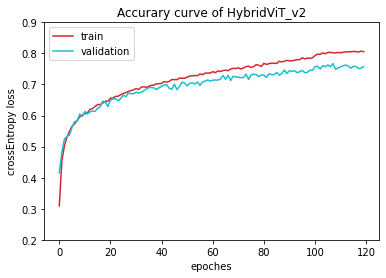

In [ ]:
plot_acc_curve(acc_record, title='HybridViT_v2')

In [37]:
def test(model, model_name, test_loader,adv_test=False):
    correct = 0
    correct_fgm = 0
    correct_pgd = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # images = resnet_feature(images)
        if adv_test:
            images_fgm = fast_gradient_method(model, images, 0.3, np.inf)
            images_pgd = projected_gradient_descent(model, images, 0.3, 0.01, 40, np.inf)
        # calculate outputs by running images through the network
        outputs = model(images)
        if adv_test:
            outputs_fgm = model(images_fgm)
            outputs_pgd = model(images_pgd)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        if adv_test:
            _, predicted_fgm = torch.max(outputs_fgm.data, 1)
            _, predicted_pgd = torch.max(outputs_pgd.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if adv_test:
            correct_fgm += (predicted_fgm == labels).sum().item()
            correct_pgd += (predicted_pgd == labels).sum().item()

    print('Accuracy of the %s on the 10000 test images: %d %%' % (model_name,
        100 * correct / total))
    if adv_test:
        print('Accuracy of the %s on the 10000 FGM adversarial images: %d %%' % (model_name,
            100 * correct / total))
        print('Accuracy of the %s on the 10000 PFD adversarial images: %d %%' % (model_name,
            100 * correct / total))

In [ ]:
test(model, 'HybridViT_v2', test_loader)

Accuracy of the HybridViT_v2 on the 10000 test images: 70 %
Accuracy of the HybridViT_v2 on the 10000 FGM adversarial images: 70 %
Accuracy of the HybridViT_v2 on the 10000 PFD adversarial images: 70 %


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/model4.pth'
torch.save(model.state_dict(), PATH)
np.save('/content/drive/MyDrive/loss_record_model4.npy',loss_record)
np.save('/content/drive/MyDrive/acc_record_model4.npy',acc_record)

In [ ]:
PATH = '/content/drive/MyDrive/model4.pth'
torch.save(model.state_dict(), PATH)

In [73]:
loss_record=np.load('/content/drive/MyDrive/loss_record_model4.npy',allow_pickle=True).item()
acc_record=np.load('/content/drive/MyDrive/acc_record_model4.npy',allow_pickle=True).item()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model4.pth'))


<All keys matched successfully>

In [ ]:
#model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 2. Experienment 1: resnet34

In [19]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [20]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [21]:
def ResNet40(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([5, 5, 6, 3], input_channels, classes)

In [23]:
macs, params = get_model_complexity_info(resnet40, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.09 GMac
Number of parameters:           21.74 M 


In [63]:
resnet40 = ResNet40(input_channels=3, classes=10).to(device)

In [64]:
resnet40_loss_record = {'train': [], 'validation': []} 
resnet40_acc_record = {'train': [], 'validation': []} 

In [65]:
resnet40_opt = torch.optim.Adam(resnet40.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(resnet40_opt, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [66]:
epochs=120

In [67]:
train(epochs, resnet40, train_loader, valid_loader, resnet40_loss_record, resnet40_acc_record, criterion=criterion, optimizer=resnet40_opt, scheduler=scheduler)

current lr = 0.000120



Epoch : 1 - loss : 1.8447 - acc: 0.3167 - val_loss : 1.6953 - val_acc: 0.3772

current lr = 0.000128



Epoch : 2 - loss : 1.5815 - acc: 0.4205 - val_loss : 1.5459 - val_acc: 0.4348

current lr = 0.000151



Epoch : 3 - loss : 1.4790 - acc: 0.4627 - val_loss : 1.4436 - val_acc: 0.4801

current lr = 0.000191



Epoch : 4 - loss : 1.4184 - acc: 0.4876 - val_loss : 1.3902 - val_acc: 0.5036

current lr = 0.000245



Epoch : 5 - loss : 1.3601 - acc: 0.5090 - val_loss : 1.3792 - val_acc: 0.5077

current lr = 0.000313



Epoch : 6 - loss : 1.3181 - acc: 0.5291 - val_loss : 1.3132 - val_acc: 0.5322

current lr = 0.000395



Epoch : 7 - loss : 1.2734 - acc: 0.5462 - val_loss : 1.2895 - val_acc: 0.5362

current lr = 0.000490



Epoch : 8 - loss : 1.2428 - acc: 0.5577 - val_loss : 1.1972 - val_acc: 0.5721

current lr = 0.000597



Epoch : 9 - loss : 1.1899 - acc: 0.5801 - val_loss : 1.2266 - val_acc: 0.5712

current lr = 0.000714



Epoch : 10 - loss : 1.1618 - acc: 0.5910 - val_loss : 1.1892 - val_acc: 0.5889

current lr = 0.000840



Epoch : 11 - loss : 1.1410 - acc: 0.5983 - val_loss : 1.1100 - val_acc: 0.6199

current lr = 0.000975



Epoch : 12 - loss : 1.1136 - acc: 0.6089 - val_loss : 1.1347 - val_acc: 0.5990

current lr = 0.001115



Epoch : 13 - loss : 1.0919 - acc: 0.6150 - val_loss : 1.1476 - val_acc: 0.5972

current lr = 0.001261



Epoch : 14 - loss : 1.0574 - acc: 0.6287 - val_loss : 1.0780 - val_acc: 0.6270

current lr = 0.001410



Epoch : 15 - loss : 1.0666 - acc: 0.6276 - val_loss : 1.1096 - val_acc: 0.6156

current lr = 0.001560



Epoch : 16 - loss : 1.0637 - acc: 0.6292 - val_loss : 1.0951 - val_acc: 0.6204

current lr = 0.001711



Epoch : 17 - loss : 1.0204 - acc: 0.6451 - val_loss : 1.0392 - val_acc: 0.6437

current lr = 0.001860



Epoch : 18 - loss : 0.9666 - acc: 0.6654 - val_loss : 1.0102 - val_acc: 0.6505

current lr = 0.002005



Epoch : 19 - loss : 1.2366 - acc: 0.5890 - val_loss : 1.2382 - val_acc: 0.5733

current lr = 0.002146



Epoch : 20 - loss : 1.0809 - acc: 0.6269 - val_loss : 1.1080 - val_acc: 0.6117

current lr = 0.002280



Epoch : 21 - loss : 1.0134 - acc: 0.6484 - val_loss : 0.9738 - val_acc: 0.6587

current lr = 0.002407



Epoch : 22 - loss : 0.9778 - acc: 0.6601 - val_loss : 0.9543 - val_acc: 0.6672

current lr = 0.002524



Epoch : 23 - loss : 0.9111 - acc: 0.6825 - val_loss : 0.9698 - val_acc: 0.6591

current lr = 0.002631



Epoch : 24 - loss : 0.8907 - acc: 0.6893 - val_loss : 0.9048 - val_acc: 0.6823

current lr = 0.002725



Epoch : 25 - loss : 1.1747 - acc: 0.5992 - val_loss : 1.1238 - val_acc: 0.6035

current lr = 0.002807



Epoch : 26 - loss : 0.9754 - acc: 0.6599 - val_loss : 0.9524 - val_acc: 0.6697

current lr = 0.002876



Epoch : 27 - loss : 0.9299 - acc: 0.6793 - val_loss : 1.5668 - val_acc: 0.4555

current lr = 0.002930



Epoch : 28 - loss : 1.3206 - acc: 0.5422 - val_loss : 1.2230 - val_acc: 0.5890

current lr = 0.002969



Epoch : 29 - loss : 1.0074 - acc: 0.6475 - val_loss : 1.0013 - val_acc: 0.6652

current lr = 0.002992



Epoch : 30 - loss : 0.9371 - acc: 0.6732 - val_loss : 0.9098 - val_acc: 0.6865

current lr = 0.003000



Epoch : 31 - loss : 0.8644 - acc: 0.6998 - val_loss : 0.8843 - val_acc: 0.6872

current lr = 0.002998



Epoch : 32 - loss : 0.8459 - acc: 0.7053 - val_loss : 0.8923 - val_acc: 0.6937

current lr = 0.002994



Epoch : 33 - loss : 0.8227 - acc: 0.7129 - val_loss : 0.8567 - val_acc: 0.7014

current lr = 0.002986



Epoch : 34 - loss : 0.7962 - acc: 0.7232 - val_loss : 0.8522 - val_acc: 0.7064

current lr = 0.002976



Epoch : 35 - loss : 0.7795 - acc: 0.7306 - val_loss : 0.8232 - val_acc: 0.7116

current lr = 0.002962



Epoch : 36 - loss : 0.7698 - acc: 0.7309 - val_loss : 0.8369 - val_acc: 0.7111

current lr = 0.002946



Epoch : 37 - loss : 0.7535 - acc: 0.7398 - val_loss : 0.8232 - val_acc: 0.7106

current lr = 0.002926



Epoch : 38 - loss : 0.7448 - acc: 0.7415 - val_loss : 0.8298 - val_acc: 0.7127

current lr = 0.002904



Epoch : 39 - loss : 0.7345 - acc: 0.7440 - val_loss : 0.8255 - val_acc: 0.7279

current lr = 0.002879



Epoch : 40 - loss : 0.7230 - acc: 0.7499 - val_loss : 0.8006 - val_acc: 0.7192

current lr = 0.002851



Epoch : 41 - loss : 0.7108 - acc: 0.7528 - val_loss : 0.8227 - val_acc: 0.7182

current lr = 0.002821



Epoch : 42 - loss : 0.6976 - acc: 0.7585 - val_loss : 0.8046 - val_acc: 0.7249

current lr = 0.002787



Epoch : 43 - loss : 0.6999 - acc: 0.7577 - val_loss : 0.7797 - val_acc: 0.7304

current lr = 0.002752



Epoch : 44 - loss : 0.6858 - acc: 0.7606 - val_loss : 0.7713 - val_acc: 0.7267

current lr = 0.002713



Epoch : 45 - loss : 0.6647 - acc: 0.7689 - val_loss : 0.7761 - val_acc: 0.7339

current lr = 0.002673



Epoch : 46 - loss : 0.6650 - acc: 0.7698 - val_loss : 0.7320 - val_acc: 0.7524

current lr = 0.002629



Epoch : 47 - loss : 0.6446 - acc: 0.7754 - val_loss : 0.7782 - val_acc: 0.7318

current lr = 0.002584



Epoch : 48 - loss : 0.6467 - acc: 0.7768 - val_loss : 0.7626 - val_acc: 0.7356

current lr = 0.002536



Epoch : 49 - loss : 0.6265 - acc: 0.7818 - val_loss : 0.7523 - val_acc: 0.7408

current lr = 0.002487



Epoch : 50 - loss : 0.6170 - acc: 0.7856 - val_loss : 0.7185 - val_acc: 0.7580

current lr = 0.002435



Epoch : 51 - loss : 0.6134 - acc: 0.7852 - val_loss : 0.7290 - val_acc: 0.7501

current lr = 0.002381



Epoch : 52 - loss : 0.5964 - acc: 0.7930 - val_loss : 0.7670 - val_acc: 0.7429

current lr = 0.002326



Epoch : 53 - loss : 0.5884 - acc: 0.7943 - val_loss : 0.7133 - val_acc: 0.7539

current lr = 0.002269



Epoch : 54 - loss : 0.5765 - acc: 0.8000 - val_loss : 0.7369 - val_acc: 0.7398

current lr = 0.002210



Epoch : 55 - loss : 0.5756 - acc: 0.7994 - val_loss : 0.7107 - val_acc: 0.7555

current lr = 0.002150



Epoch : 56 - loss : 0.5634 - acc: 0.8032 - val_loss : 0.7074 - val_acc: 0.7592

current lr = 0.002089



Epoch : 57 - loss : 0.5450 - acc: 0.8113 - val_loss : 0.6998 - val_acc: 0.7659

current lr = 0.002027



Epoch : 58 - loss : 0.5415 - acc: 0.8096 - val_loss : 0.6924 - val_acc: 0.7655

current lr = 0.001963



Epoch : 59 - loss : 0.5276 - acc: 0.8157 - val_loss : 0.7008 - val_acc: 0.7707

current lr = 0.001899



Epoch : 60 - loss : 0.5161 - acc: 0.8192 - val_loss : 0.7043 - val_acc: 0.7616

current lr = 0.001833



Epoch : 61 - loss : 0.5110 - acc: 0.8200 - val_loss : 0.6852 - val_acc: 0.7689

current lr = 0.001767



Epoch : 62 - loss : 0.5033 - acc: 0.8244 - val_loss : 0.6586 - val_acc: 0.7789

current lr = 0.001701



Epoch : 63 - loss : 0.4952 - acc: 0.8278 - val_loss : 0.6848 - val_acc: 0.7769

current lr = 0.001634



Epoch : 64 - loss : 0.4845 - acc: 0.8308 - val_loss : 0.6813 - val_acc: 0.7726

current lr = 0.001567



Epoch : 65 - loss : 0.4732 - acc: 0.8329 - val_loss : 0.6697 - val_acc: 0.7778

current lr = 0.001500



Epoch : 66 - loss : 0.4672 - acc: 0.8363 - val_loss : 0.6446 - val_acc: 0.7846

current lr = 0.001432



Epoch : 67 - loss : 0.4483 - acc: 0.8432 - val_loss : 0.6438 - val_acc: 0.7830

current lr = 0.001365



Epoch : 68 - loss : 0.4453 - acc: 0.8447 - val_loss : 0.6625 - val_acc: 0.7778

current lr = 0.001298



Epoch : 69 - loss : 0.4384 - acc: 0.8457 - val_loss : 0.6481 - val_acc: 0.7816

current lr = 0.001232



Epoch : 70 - loss : 0.4255 - acc: 0.8508 - val_loss : 0.6727 - val_acc: 0.7796

current lr = 0.001166



Epoch : 71 - loss : 0.4174 - acc: 0.8550 - val_loss : 0.6931 - val_acc: 0.7675

current lr = 0.001101



Epoch : 72 - loss : 0.4092 - acc: 0.8580 - val_loss : 0.6739 - val_acc: 0.7885

current lr = 0.001036



Epoch : 73 - loss : 0.4001 - acc: 0.8586 - val_loss : 0.6708 - val_acc: 0.7832

current lr = 0.000973



Epoch : 74 - loss : 0.3938 - acc: 0.8617 - val_loss : 0.6658 - val_acc: 0.7835

current lr = 0.000910



Epoch : 75 - loss : 0.3860 - acc: 0.8639 - val_loss : 0.6564 - val_acc: 0.7866

current lr = 0.000849



Epoch : 76 - loss : 0.3746 - acc: 0.8670 - val_loss : 0.6604 - val_acc: 0.7836

current lr = 0.000789



Epoch : 77 - loss : 0.3635 - acc: 0.8729 - val_loss : 0.6575 - val_acc: 0.7873

current lr = 0.000730



Epoch : 78 - loss : 0.3640 - acc: 0.8727 - val_loss : 0.6435 - val_acc: 0.7951

current lr = 0.000673



Epoch : 79 - loss : 0.3546 - acc: 0.8770 - val_loss : 0.6482 - val_acc: 0.7887

current lr = 0.000618



Epoch : 80 - loss : 0.3437 - acc: 0.8794 - val_loss : 0.6466 - val_acc: 0.7948

current lr = 0.000564



Epoch : 81 - loss : 0.3379 - acc: 0.8800 - val_loss : 0.6256 - val_acc: 0.7984

current lr = 0.000513



Epoch : 82 - loss : 0.3416 - acc: 0.8799 - val_loss : 0.6651 - val_acc: 0.7866

current lr = 0.000463



Epoch : 83 - loss : 0.3279 - acc: 0.8821 - val_loss : 0.6898 - val_acc: 0.7853

current lr = 0.000416



Epoch : 84 - loss : 0.3249 - acc: 0.8861 - val_loss : 0.6632 - val_acc: 0.7893

current lr = 0.000370



Epoch : 85 - loss : 0.3183 - acc: 0.8890 - val_loss : 0.6479 - val_acc: 0.7973

current lr = 0.000327



Epoch : 86 - loss : 0.3084 - acc: 0.8910 - val_loss : 0.6437 - val_acc: 0.8038

current lr = 0.000286



Epoch : 87 - loss : 0.3063 - acc: 0.8925 - val_loss : 0.6496 - val_acc: 0.8030

current lr = 0.000248



Epoch : 88 - loss : 0.3018 - acc: 0.8936 - val_loss : 0.6341 - val_acc: 0.8073

current lr = 0.000212



Epoch : 89 - loss : 0.2964 - acc: 0.8959 - val_loss : 0.6456 - val_acc: 0.8012

current lr = 0.000179



Epoch : 90 - loss : 0.2886 - acc: 0.8972 - val_loss : 0.6326 - val_acc: 0.8036

current lr = 0.000148



Epoch : 91 - loss : 0.2914 - acc: 0.8969 - val_loss : 0.6660 - val_acc: 0.8029

current lr = 0.000121



Epoch : 92 - loss : 0.2907 - acc: 0.8982 - val_loss : 0.6730 - val_acc: 0.7915

current lr = 0.000096



Epoch : 93 - loss : 0.2857 - acc: 0.9015 - val_loss : 0.6480 - val_acc: 0.7985

current lr = 0.000073



Epoch : 94 - loss : 0.2752 - acc: 0.9048 - val_loss : 0.6475 - val_acc: 0.7970

current lr = 0.000054



Epoch : 95 - loss : 0.2764 - acc: 0.9018 - val_loss : 0.6737 - val_acc: 0.7959

current lr = 0.000038



Epoch : 96 - loss : 0.2813 - acc: 0.9018 - val_loss : 0.6479 - val_acc: 0.8014

current lr = 0.000024



Epoch : 97 - loss : 0.2752 - acc: 0.9038 - val_loss : 0.6355 - val_acc: 0.8016

current lr = 0.000014



Epoch : 98 - loss : 0.2761 - acc: 0.9030 - val_loss : 0.6424 - val_acc: 0.8018

current lr = 0.000006



Epoch : 99 - loss : 0.2763 - acc: 0.9020 - val_loss : 0.6519 - val_acc: 0.8026

current lr = 0.000002



Epoch : 100 - loss : 0.2791 - acc: 0.9022 - val_loss : 0.6570 - val_acc: 0.7988

current lr = 0.000000


ValueError: ignored

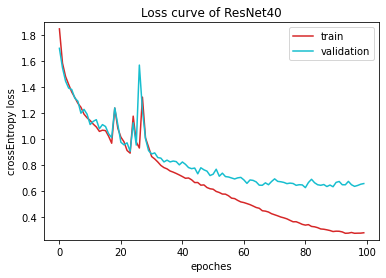

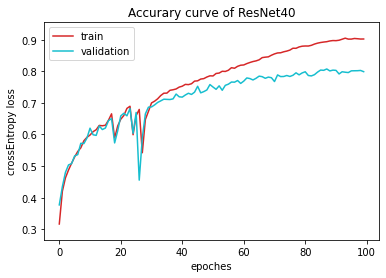

In [68]:
plot_loss_curve(resnet40_loss_record, title='ResNet40')
plot_acc_curve(resnet40_acc_record, title='ResNet40')

In [69]:
test(resnet40,'ResNet40', test_loader)

Accuracy of the ResNet40 on the 10000 test images: 75 %


In [70]:
torch.save(resnet40.state_dict(), '/content/drive/MyDrive/resnet40.pth')
np.save('/content/drive/MyDrive/loss_record_resnet40.npy',resnet40_loss_record)
np.save('/content/drive/MyDrive/acc_record_resnet40.npy',resnet40_acc_record)

comparison

In [71]:
def loss_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

def acc_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('accuracy comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

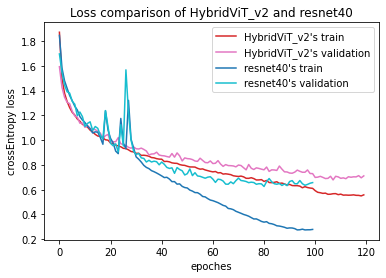

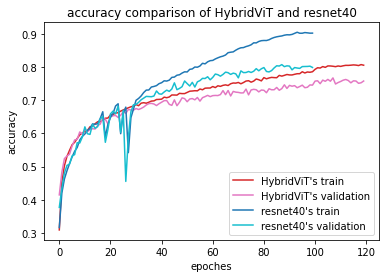

In [74]:
loss_comparison_of_two(loss_record, resnet40_loss_record, 'HybridViT_v2', 'resnet40')
acc_comparison_of_two(acc_record, resnet40_acc_record, 'HybridViT', 'resnet40')

## 3. experiment 2: model with similar FLOPs

In [75]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [76]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [77]:
def ResNet71(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([4, 6, 7, 6], input_channels, classes)

In [102]:
resnet71=ResNet71(3,10).to(device)

In [103]:
resnet71_loss_record = {'train': [], 'validation': []} 
resnet71_acc_record = {'train': [], 'validation': []} 

In [104]:
lr=3e-3
epochs=100

In [105]:
resnet71_opt = torch.optim.Adam(resnet71.parameters(), lr=lr)
resnet71_epochs=epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(resnet71_opt, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [106]:
def train(epochs, model, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer, scheduler=None, resnet_feature=None, adv_train=False):
    #optimizer.zero_grad()
    #optimizer.step()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        print("current lr = %lf"%optimizer.param_groups[0]['lr'])

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            # with torch.no_grad():
            #     data = resnet_feature(data)
            if adv_train:
                # Replace clean example with adversarial example for adversarial training
                data = projected_gradient_descent(model, data, 0.3, 0.01, 40, np.inf)
            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
        
        # scheduler.step()

        loss_record['train'].append(epoch_loss.detach().cpu().item())
        acc_record['train'].append(epoch_accuracy.detach().cpu().item())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)
                # data = resnet_feature(data)
                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
            loss_record['validation'].append(epoch_val_loss.detach().cpu().item())
            acc_record['validation'].append(epoch_val_accuracy.detach().cpu().item())

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

In [107]:
train(epochs, resnet71, train_loader, valid_loader, resnet71_loss_record, resnet71_acc_record, criterion, resnet71_opt,scheduler)

current lr = 0.000120



Epoch : 1 - loss : 2.1257 - acc: 0.2289 - val_loss : 1.9474 - val_acc: 0.2862

current lr = 0.000128



Epoch : 2 - loss : 1.8654 - acc: 0.3147 - val_loss : 1.8171 - val_acc: 0.3355

current lr = 0.000151



Epoch : 3 - loss : 1.7681 - acc: 0.3587 - val_loss : 1.6969 - val_acc: 0.3837

current lr = 0.000191



Epoch : 4 - loss : 1.6893 - acc: 0.3935 - val_loss : 1.7085 - val_acc: 0.4052

current lr = 0.000245



Epoch : 5 - loss : 1.6454 - acc: 0.4207 - val_loss : 1.6098 - val_acc: 0.4291

current lr = 0.000313



Epoch : 6 - loss : 1.5733 - acc: 0.4474 - val_loss : 1.5273 - val_acc: 0.4446

current lr = 0.000395



Epoch : 7 - loss : 1.5869 - acc: 0.4604 - val_loss : 1.5896 - val_acc: 0.4335

current lr = 0.000490



Epoch : 8 - loss : 1.6769 - acc: 0.4399 - val_loss : 1.6892 - val_acc: 0.4245

current lr = 0.000597



Epoch : 9 - loss : 1.7244 - acc: 0.4254 - val_loss : 1.6941 - val_acc: 0.4458

current lr = 0.000714



Epoch : 10 - loss : 1.7063 - acc: 0.4513 - val_loss : 1.9039 - val_acc: 0.3873

current lr = 0.000840



Epoch : 11 - loss : 1.7500 - acc: 0.4352 - val_loss : 1.6124 - val_acc: 0.4705

current lr = 0.000975



Epoch : 12 - loss : 1.7392 - acc: 0.4527 - val_loss : 1.7428 - val_acc: 0.4495

current lr = 0.001115



Epoch : 13 - loss : 1.8475 - acc: 0.4483 - val_loss : 2.3909 - val_acc: 0.3786

current lr = 0.001261



Epoch : 14 - loss : 2.1791 - acc: 0.3533 - val_loss : 1.8889 - val_acc: 0.3914

current lr = 0.001410



Epoch : 15 - loss : 2.0397 - acc: 0.3499 - val_loss : 2.0419 - val_acc: 0.3917

current lr = 0.001560



Epoch : 16 - loss : 1.8281 - acc: 0.4195 - val_loss : 1.8762 - val_acc: 0.4305

current lr = 0.001711



Epoch : 17 - loss : 1.6890 - acc: 0.4609 - val_loss : 1.8083 - val_acc: 0.4424

current lr = 0.001860



Epoch : 18 - loss : 1.6623 - acc: 0.4538 - val_loss : 1.6988 - val_acc: 0.4609

current lr = 0.002005



Epoch : 19 - loss : 1.8590 - acc: 0.4290 - val_loss : 1.9890 - val_acc: 0.3854

current lr = 0.002146



Epoch : 20 - loss : 1.9054 - acc: 0.4103 - val_loss : 2.0040 - val_acc: 0.3979

current lr = 0.002280



Epoch : 21 - loss : 1.6981 - acc: 0.4537 - val_loss : 1.7421 - val_acc: 0.4743

current lr = 0.002407



Epoch : 22 - loss : 1.6869 - acc: 0.4508 - val_loss : 1.4951 - val_acc: 0.4829

current lr = 0.002524



Epoch : 23 - loss : 1.6247 - acc: 0.4722 - val_loss : 1.4835 - val_acc: 0.4791

current lr = 0.002631



Epoch : 24 - loss : 1.5993 - acc: 0.4733 - val_loss : 1.6664 - val_acc: 0.4706

current lr = 0.002725



Epoch : 25 - loss : 1.5422 - acc: 0.4956 - val_loss : 1.5620 - val_acc: 0.5185

current lr = 0.002807



Epoch : 26 - loss : 1.4535 - acc: 0.5164 - val_loss : 1.4606 - val_acc: 0.5286

current lr = 0.002876



Epoch : 27 - loss : 1.3807 - acc: 0.5324 - val_loss : 1.3854 - val_acc: 0.5294

current lr = 0.002930



Epoch : 28 - loss : 1.3717 - acc: 0.5431 - val_loss : 1.3746 - val_acc: 0.5418

current lr = 0.002969



Epoch : 29 - loss : 1.3628 - acc: 0.5405 - val_loss : 1.2941 - val_acc: 0.5482

current lr = 0.002992



Epoch : 30 - loss : 1.3031 - acc: 0.5551 - val_loss : 1.2772 - val_acc: 0.5465

current lr = 0.003000



Epoch : 31 - loss : 1.2651 - acc: 0.5640 - val_loss : 1.2075 - val_acc: 0.5772

current lr = 0.002998



Epoch : 32 - loss : 1.3079 - acc: 0.5499 - val_loss : 1.2580 - val_acc: 0.5693

current lr = 0.002994



Epoch : 33 - loss : 1.2189 - acc: 0.5783 - val_loss : 1.2080 - val_acc: 0.5845

current lr = 0.002986



Epoch : 34 - loss : 1.1738 - acc: 0.5931 - val_loss : 1.2064 - val_acc: 0.5808

current lr = 0.002976



Epoch : 35 - loss : 1.1505 - acc: 0.5975 - val_loss : 1.1790 - val_acc: 0.5969

current lr = 0.002962



Epoch : 36 - loss : 1.1247 - acc: 0.6053 - val_loss : 1.1364 - val_acc: 0.6075

current lr = 0.002946



Epoch : 37 - loss : 1.1016 - acc: 0.6148 - val_loss : 1.1182 - val_acc: 0.6067

current lr = 0.002926



Epoch : 38 - loss : 1.3197 - acc: 0.5360 - val_loss : 1.3095 - val_acc: 0.5517

current lr = 0.002904



Epoch : 39 - loss : 1.1936 - acc: 0.5826 - val_loss : 1.2117 - val_acc: 0.5676

current lr = 0.002879



Epoch : 40 - loss : 1.1293 - acc: 0.6062 - val_loss : 1.1225 - val_acc: 0.6066

current lr = 0.002851



Epoch : 41 - loss : 1.0903 - acc: 0.6162 - val_loss : 1.0999 - val_acc: 0.6158

current lr = 0.002821



Epoch : 42 - loss : 1.0499 - acc: 0.6313 - val_loss : 1.0986 - val_acc: 0.6161

current lr = 0.002787



Epoch : 43 - loss : 1.0252 - acc: 0.6403 - val_loss : 1.0588 - val_acc: 0.6262

current lr = 0.002752



Epoch : 44 - loss : 0.9956 - acc: 0.6508 - val_loss : 1.0519 - val_acc: 0.6315

current lr = 0.002713



Epoch : 45 - loss : 0.9754 - acc: 0.6588 - val_loss : 1.0325 - val_acc: 0.6442

current lr = 0.002673



Epoch : 46 - loss : 0.9687 - acc: 0.6620 - val_loss : 1.0080 - val_acc: 0.6412

current lr = 0.002629



Epoch : 47 - loss : 0.9372 - acc: 0.6724 - val_loss : 0.9757 - val_acc: 0.6619

current lr = 0.002584



Epoch : 48 - loss : 0.9488 - acc: 0.6726 - val_loss : 1.0506 - val_acc: 0.6380

current lr = 0.002536



Epoch : 49 - loss : 0.9318 - acc: 0.6756 - val_loss : 0.9647 - val_acc: 0.6654

current lr = 0.002487



Epoch : 50 - loss : 0.9015 - acc: 0.6864 - val_loss : 0.9467 - val_acc: 0.6673

current lr = 0.002435



Epoch : 51 - loss : 0.8715 - acc: 0.6958 - val_loss : 0.9181 - val_acc: 0.6788

current lr = 0.002381



Epoch : 52 - loss : 0.8565 - acc: 0.7042 - val_loss : 0.8979 - val_acc: 0.6897

current lr = 0.002326



Epoch : 53 - loss : 0.8394 - acc: 0.7078 - val_loss : 0.8905 - val_acc: 0.6970

current lr = 0.002269



Epoch : 54 - loss : 0.8238 - acc: 0.7126 - val_loss : 0.8842 - val_acc: 0.6870

current lr = 0.002210



Epoch : 55 - loss : 0.8243 - acc: 0.7138 - val_loss : 0.9039 - val_acc: 0.6908

current lr = 0.002150



Epoch : 56 - loss : 0.8085 - acc: 0.7204 - val_loss : 0.8861 - val_acc: 0.7004

current lr = 0.002089



Epoch : 57 - loss : 0.7807 - acc: 0.7301 - val_loss : 0.8636 - val_acc: 0.7022

current lr = 0.002027



Epoch : 58 - loss : 0.7759 - acc: 0.7292 - val_loss : 0.8335 - val_acc: 0.7046

current lr = 0.001963



Epoch : 59 - loss : 0.7597 - acc: 0.7361 - val_loss : 0.8556 - val_acc: 0.6995

current lr = 0.001899



Epoch : 60 - loss : 0.7401 - acc: 0.7425 - val_loss : 0.8314 - val_acc: 0.7135

current lr = 0.001833



Epoch : 61 - loss : 0.7341 - acc: 0.7438 - val_loss : 0.8316 - val_acc: 0.7186

current lr = 0.001767



Epoch : 62 - loss : 0.7202 - acc: 0.7485 - val_loss : 0.8087 - val_acc: 0.7256

current lr = 0.001701



Epoch : 63 - loss : 0.7005 - acc: 0.7542 - val_loss : 0.8241 - val_acc: 0.7163

current lr = 0.001634



Epoch : 64 - loss : 0.6941 - acc: 0.7589 - val_loss : 0.7919 - val_acc: 0.7285

current lr = 0.001567



Epoch : 65 - loss : 0.6807 - acc: 0.7629 - val_loss : 0.8074 - val_acc: 0.7187

current lr = 0.001500



Epoch : 66 - loss : 0.6668 - acc: 0.7689 - val_loss : 0.7668 - val_acc: 0.7332

current lr = 0.001432



Epoch : 67 - loss : 0.6560 - acc: 0.7721 - val_loss : 0.7896 - val_acc: 0.7276

current lr = 0.001365



Epoch : 68 - loss : 0.6384 - acc: 0.7791 - val_loss : 0.7759 - val_acc: 0.7302

current lr = 0.001298



Epoch : 69 - loss : 0.6596 - acc: 0.7706 - val_loss : 0.7753 - val_acc: 0.7280

current lr = 0.001232



Epoch : 70 - loss : 0.6194 - acc: 0.7837 - val_loss : 0.7560 - val_acc: 0.7472

current lr = 0.001166



Epoch : 71 - loss : 0.6107 - acc: 0.7874 - val_loss : 0.7624 - val_acc: 0.7396

current lr = 0.001101



Epoch : 72 - loss : 0.5910 - acc: 0.7936 - val_loss : 0.7482 - val_acc: 0.7401

current lr = 0.001036



Epoch : 73 - loss : 0.5836 - acc: 0.7952 - val_loss : 0.7494 - val_acc: 0.7420

current lr = 0.000973



Epoch : 74 - loss : 0.5735 - acc: 0.8010 - val_loss : 0.7244 - val_acc: 0.7560

current lr = 0.000910



Epoch : 75 - loss : 0.5579 - acc: 0.8061 - val_loss : 0.7353 - val_acc: 0.7497

current lr = 0.000849



Epoch : 76 - loss : 0.5466 - acc: 0.8101 - val_loss : 0.7259 - val_acc: 0.7574

current lr = 0.000789



Epoch : 77 - loss : 0.5317 - acc: 0.8150 - val_loss : 0.7092 - val_acc: 0.7558

current lr = 0.000730



Epoch : 78 - loss : 0.5241 - acc: 0.8168 - val_loss : 0.7172 - val_acc: 0.7540

current lr = 0.000673



Epoch : 79 - loss : 0.5187 - acc: 0.8194 - val_loss : 0.7090 - val_acc: 0.7554

current lr = 0.000618



Epoch : 80 - loss : 0.5072 - acc: 0.8223 - val_loss : 0.7177 - val_acc: 0.7565

current lr = 0.000564



Epoch : 81 - loss : 0.4977 - acc: 0.8261 - val_loss : 0.6974 - val_acc: 0.7694

current lr = 0.000513



Epoch : 82 - loss : 0.4845 - acc: 0.8301 - val_loss : 0.6964 - val_acc: 0.7622

current lr = 0.000463



Epoch : 83 - loss : 0.4810 - acc: 0.8320 - val_loss : 0.7007 - val_acc: 0.7653

current lr = 0.000416



Epoch : 84 - loss : 0.4706 - acc: 0.8331 - val_loss : 0.6835 - val_acc: 0.7727

current lr = 0.000370



Epoch : 85 - loss : 0.4645 - acc: 0.8379 - val_loss : 0.6934 - val_acc: 0.7672

current lr = 0.000327



Epoch : 86 - loss : 0.4465 - acc: 0.8417 - val_loss : 0.6727 - val_acc: 0.7753

current lr = 0.000286



Epoch : 87 - loss : 0.4436 - acc: 0.8455 - val_loss : 0.6559 - val_acc: 0.7818

current lr = 0.000248



Epoch : 88 - loss : 0.4359 - acc: 0.8465 - val_loss : 0.6942 - val_acc: 0.7703

current lr = 0.000212



Epoch : 89 - loss : 0.4341 - acc: 0.8489 - val_loss : 0.6723 - val_acc: 0.7741

current lr = 0.000179



Epoch : 90 - loss : 0.4258 - acc: 0.8514 - val_loss : 0.6775 - val_acc: 0.7763

current lr = 0.000148



Epoch : 91 - loss : 0.4211 - acc: 0.8515 - val_loss : 0.6640 - val_acc: 0.7833

current lr = 0.000121



Epoch : 92 - loss : 0.4155 - acc: 0.8552 - val_loss : 0.6683 - val_acc: 0.7802

current lr = 0.000096



Epoch : 93 - loss : 0.4207 - acc: 0.8538 - val_loss : 0.6667 - val_acc: 0.7784

current lr = 0.000073



Epoch : 94 - loss : 0.4100 - acc: 0.8554 - val_loss : 0.6937 - val_acc: 0.7779

current lr = 0.000054



Epoch : 95 - loss : 0.4036 - acc: 0.8598 - val_loss : 0.6812 - val_acc: 0.7749

current lr = 0.000038



Epoch : 96 - loss : 0.4029 - acc: 0.8598 - val_loss : 0.6787 - val_acc: 0.7763

current lr = 0.000024



Epoch : 97 - loss : 0.4087 - acc: 0.8572 - val_loss : 0.6864 - val_acc: 0.7757

current lr = 0.000014



Epoch : 98 - loss : 0.4004 - acc: 0.8603 - val_loss : 0.7005 - val_acc: 0.7762

current lr = 0.000006



Epoch : 99 - loss : 0.4037 - acc: 0.8588 - val_loss : 0.6774 - val_acc: 0.7780

current lr = 0.000002



Epoch : 100 - loss : 0.4012 - acc: 0.8589 - val_loss : 0.6950 - val_acc: 0.7777



In [108]:
test(resnet71, 'ResNet71',test_loader)

Accuracy of the ResNet71 on the 10000 test images: 71 %


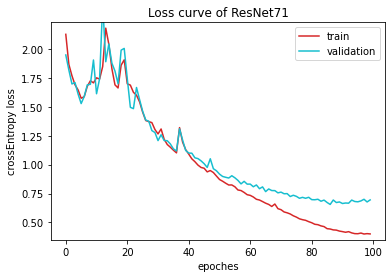

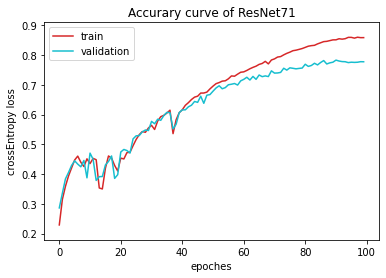

In [109]:
plot_loss_curve(resnet71_loss_record, title='ResNet71')
plot_acc_curve(resnet71_acc_record, title='ResNet71')

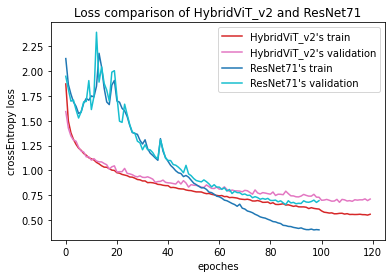

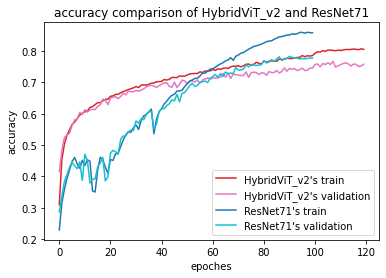

In [111]:
loss_comparison_of_two(loss_record, resnet71_loss_record, 'HybridViT_v2','ResNet71')
acc_comparison_of_two(acc_record, resnet71_acc_record,'HybridViT_v2','ResNet71')

In [126]:
def loss_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))

    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:purple', label=model_name_3+'\'s validation')
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('loss comparison of %s, %s and %s' % (model_name_1, model_name_2, model_name_3))
    plt.legend()
    plt.show()

def acc_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:purple', label=model_name_3+'\'s validation')
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('accuracy comparison of %s, %s and %s' % (model_name_1, model_name_2, model_name_3))
    plt.legend()
    plt.show()

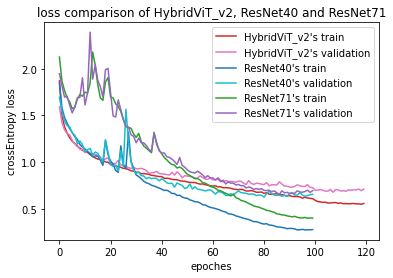

In [127]:
loss_comparison_of_three(loss_record, resnet40_loss_record, resnet71_loss_record,'HybridViT_v2','ResNet40','ResNet71')

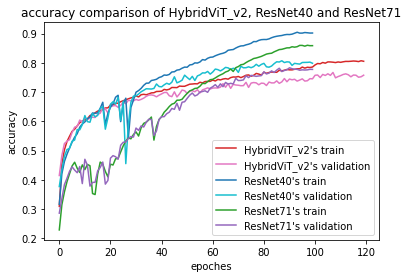

In [128]:
acc_comparison_of_three(acc_record, resnet40_acc_record, resnet71_acc_record,'HybridViT_v2','ResNet40','ResNet71')

In [129]:
torch.save(resnet71.state_dict(), '/content/drive/MyDrive/resnet71.pth')
np.save('/content/drive/MyDrive/loss_record_resnet71.npy',resnet71_loss_record)
np.save('/content/drive/MyDrive/acc_record_resnet71.npy',resnet71_acc_record)

## 4. experiment 3. model robust

In [ ]:
adv_epochs=50
adv_mobilenet_epochs=50
adv_resnet_epochs=50

In [ ]:
adv_loss_record={'train': [], 'validation': []} 
adv_acc_record={'train': [], 'validation': []} 
adv_mobilenet_loss_record={'train': [], 'validation': []} 
adv_mobilenet_acc_record={'train': [], 'validation': []} 
adv_resnet_loss_record={'train': [], 'validation': []} 
adv_resnet_acc_record={'train': [], 'validation': []} 

In [ ]:
train(adv_epochs, model, train_loader, valid_loader, adv_loss_record, adv_acc_record, criterion, optimizer, adv_train=True)
train(adv_mobilenet_epochs, mobilenet, train_loader, valid_loader, adv_mobilenet_loss_record, adv_mobilenet_acc_record, criterion, mobilenet_optimizer,adv_train=True)
train(adv_resnet_epochs, resnet, train_loader, valid_loader, adv_resnet_loss_record, adv_resnet_acc_record, criterion, resnet_optimizer,adv_train=True)

In [ ]:
loss_comparison_of_three(adv_loss_record, adv_mobilenet_loss_record, adv_resnet_loss_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
acc_comparison_of_three(adv_acc_record, adv_mobilenet_acc_record, adv_resnet_acc_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
test(model, 'robust HybridViT', test_loader)
test(mobileNet, ,'robust MobileNet_v2', test_loader)
test(resnet, 'ResNet152', test_loader)

In [ ]:
PATH = './adv_HybridViT.pth'
torch.save(model.state_dict(), PATH)
PATH = './adv_Mobilenet.pth'
torch.save(mobilenet.state_dict(), PATH)
PATH = './adv_resnet.pth'
torch.save(resnet.state_dict(), PATH)